In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from skimage import filters, morphology, util
from skimage.filters import threshold_otsu

# --- load (change this) ---
img_path = "../image1.jpg"

img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
if img_bgr is None:
    raise FileNotFoundError(img_path)
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

# float [0,1] for skimage filters
img = img_gray.astype(np.float32) / 255.0


In [3]:
def show_single(title, im, cmap="gray"):
    plt.figure(figsize=(6,6))
    plt.imshow(im, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()


In [4]:
# -------- gradient-magnitude methods (binarize with Otsu) --------
sobel_mag   = filters.sobel(img)      # ∇ magnitude approx
prewitt_mag = filters.prewitt(img)
roberts_mag = filters.roberts(img)

def binarize(mag):
    t = threshold_otsu(mag)  # auto threshold
    return (mag >= t).astype(np.uint8)

sobel_edges   = binarize(sobel_mag)
prewitt_edges = binarize(prewitt_mag)
roberts_edges = binarize(roberts_mag)

# -------- Laplacian of Gaussian (LoG) --------
# smooth then Laplacian; take abs and Otsu to get thin edges
blur = cv2.GaussianBlur(img_gray, (0,0), sigmaX=1.2, sigmaY=1.2)
lap = cv2.Laplacian(blur, ddepth=cv2.CV_32F, ksize=3)
log_mag = np.abs(lap)
# normalize 0..1 for thresholding
log_mag_norm = (log_mag - log_mag.min()) / (log_mag.max() - log_mag.min() + 1e-8)
log_edges = binarize(log_mag_norm)

# -------- Canny --------
# thresholds are in [0,255]; sigma≈1.2 pre-blur helps
blur_c = cv2.GaussianBlur(img_gray, (0,0), sigmaX=1.2, sigmaY=1.2)
canny_edges = cv2.Canny(blur_c, threshold1=60, threshold2=150, L2gradient=True) // 255


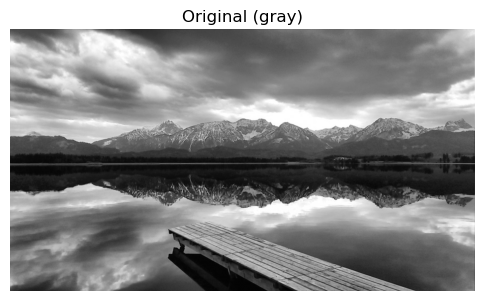

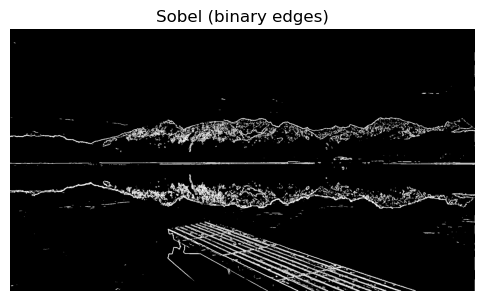

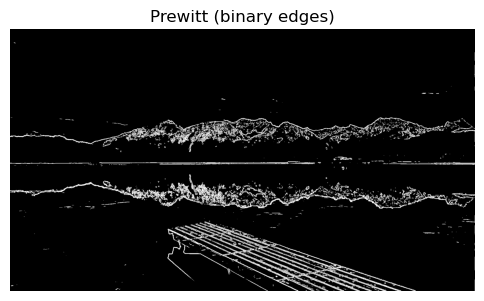

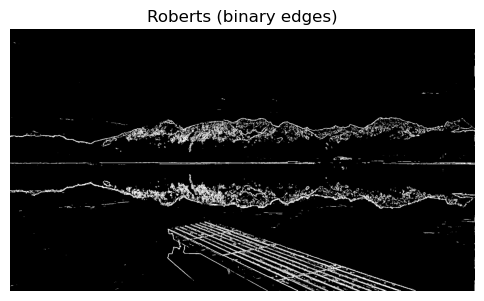

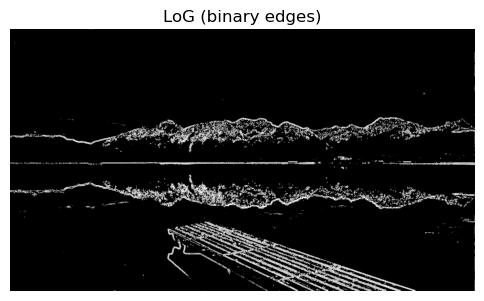

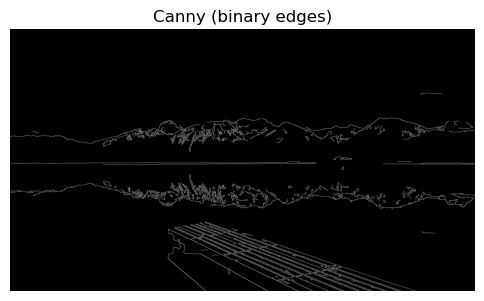

In [5]:
show_single("Original (gray)", img_gray)
show_single("Sobel (binary edges)", sobel_edges)
show_single("Prewitt (binary edges)", prewitt_edges)
show_single("Roberts (binary edges)", roberts_edges)
show_single("LoG (binary edges)", log_edges)
show_single("Canny (binary edges)", canny_edges)


In [6]:
def edge_stats(name, edge01):
    # edge01 is 0/1 uint8
    edge = edge01.astype(bool)
    density = 100.0 * edge.mean()
    # skeletonize expects boolean in [0,1]
    skel = morphology.skeletonize(edge)
    skel_count = max(1, skel.sum())
    thick_ratio = edge.sum() / skel_count
    return {"method": name, "edge_density_%": density, "thinness_ratio": thick_ratio}

stats = []
stats.append(edge_stats("Sobel",   sobel_edges))
stats.append(edge_stats("Prewitt", prewitt_edges))
stats.append(edge_stats("Roberts", roberts_edges))
stats.append(edge_stats("LoG",     log_edges))
stats.append(edge_stats("Canny",   canny_edges))

for s in stats:
    print(f"{s['method']:7s} | edge_density={s['edge_density_%']:6.2f}% | thinness_ratio={s['thinness_ratio']:.2f}")


Sobel   | edge_density=  5.25% | thinness_ratio=2.26
Prewitt | edge_density=  5.23% | thinness_ratio=2.28
Roberts | edge_density=  5.11% | thinness_ratio=2.07
LoG     | edge_density=  5.62% | thinness_ratio=2.07
Canny   | edge_density=  1.73% | thinness_ratio=1.22
